In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import yfinance as yf
import matplotlib 

print("✅ pandas:", pd.__version__)
print("✅ numpy:", np.__version__)
print("✅ matplotlib:", matplotlib.__version__)
print("✅ seaborn:", sns.__version__)
print("✅ scikit-learn:", sklearn.__version__)
print("✅ yfinance:", yf.__version__)




✅ pandas: 2.2.2
✅ numpy: 1.26.4
✅ matplotlib: 3.9.2
✅ seaborn: 0.13.2
✅ scikit-learn: 1.5.1
✅ yfinance: 0.2.55


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import ta

In [3]:
# 1. Download historical stock data
data = yf.download('AAPL', start='2023-01-01', end='2023-12-29')
print(data.shape)  


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

(249, 5)


In [4]:
# 2. Data Preprocessing
print("Before dropna:", data.shape)
print(data.isnull().sum())  # Check missing values

data = data.dropna()
print("After dropna:", data.shape)

if data.shape[0] == 0:
    raise Exception("Dataset is empty after dropping NaN values. Please check your data!")

# Moving averages
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Technical Indicators
close_series = data['Close'].squeeze()  # Make sure it's a Series, not DataFrame

# RSI
rsi_indicator = ta.momentum.RSIIndicator(close=close_series, window=14)
data['RSI'] = rsi_indicator.rsi()

# MACD
macd = ta.trend.MACD(close=close_series)
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()
data['MACD_diff'] = macd.macd_diff()

# Drop NaN rows created after indicators
data = data.dropna()
print("After indicators:", data.shape)


Before dropna: (249, 5)
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64
After dropna: (249, 5)
After indicators: (200, 12)


In [5]:
# 3. Features and Target
features = ['RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'SMA_20', 'SMA_50', 'EMA_20']
X = data[features]
y = data['Close']

In [6]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [7]:
# 5. Model Training with Hyperparameter Tuning
param_grid = {
'n_estimators': [50, 100, 150],
'max_depth': [10, 20, None],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'bootstrap': [True, False],
'max_features': ['sqrt', 'log2']
}  
rf_model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
n_iter=50, cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42)

In [8]:
# 6. Best Model
best_rf_model = random_search.best_estimator_

In [9]:
# 7. Predictions
y_pred = best_rf_model.predict(X_test)

In [10]:
# 8. Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 11.16608736083656
MAE: 2.7621787890868057
R2 Score: 0.683770565463028


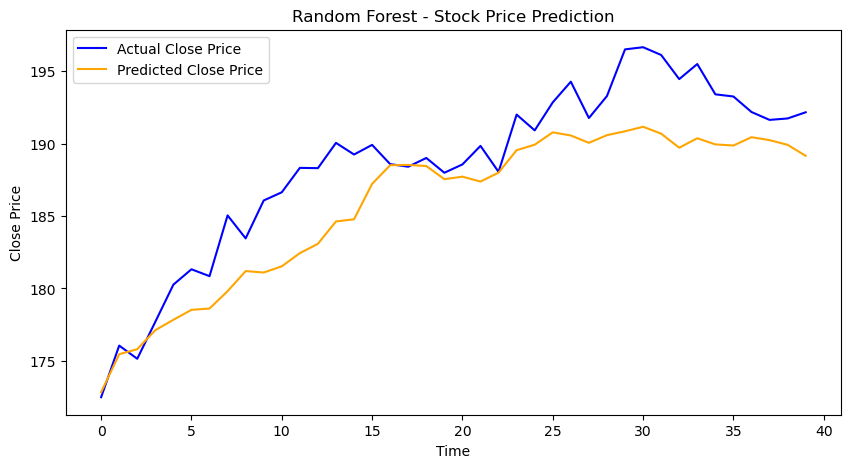

In [11]:
# 9. Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='orange')
plt.title('Random Forest - Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [12]:

# 10. Save Model
joblib.dump(best_rf_model, 'random_forest_stock_model.pkl')


['random_forest_stock_model.pkl']

In [13]:
# 11. Predict Next Day
latest_data = X.tail(1)
next_day_price = best_rf_model.predict(latest_data)
print("Predicted Next Day Price:", next_day_price[0])


Predicted Next Day Price: 189.16413780212395
